In [ ]:
import numpy as np
from numba import cuda
import math
import random
import time
import multiprocessing as mp
from functools import partial
import urllib.request
import os
import matplotlib.pyplot as plt
# sprawdzenie, czy CUDA jest dostępne
print("CUDA dostępne:", cuda.is_available())
!nvidia-smi


CUDA dostępne: True
Tue Dec  2 21:51:57 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   63C    P0             28W /   70W |     104MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+---------------------------

In [ ]:
def download_tsplib(url: str, local_name: str | None = None) -> str:
    if local_name is None:
        local_name = url.split("/")[-1]
    print(f"Pobieram {url} -> {local_name}")
    urllib.request.urlretrieve(url, local_name)
    return local_name

def load_tsplib_coords(filename: str):
    coords = []
    with open(filename, 'r') as f:
        in_node_section = False
        for line in f:
            line = line.strip()
            if line == "NODE_COORD_SECTION":
                in_node_section = True
                continue
            if line == "EOF":
                break
            if in_node_section:
                parts = line.split()
                if len(parts) >= 3:
                    x = float(parts[1])
                    y = float(parts[2])
                    coords.append((x, y))
    return coords

class TSPInstance:
    def __init__(self, coords):
        self.coords = coords
        self.n_cities = len(coords)
        self.dist_matrix = [[0.0]*self.n_cities for _ in range(self.n_cities)]
        for i in range(self.n_cities):
            for j in range(self.n_cities):
                if i != j:

                    self.dist_matrix[i][j] = math.dist(coords[i], coords[j])

    def tour_length(self, tour):
        total = 0.0
        for i in range(len(tour)):
            a = tour[i]
            b = tour[(i + 1) % len(tour)]
            total += self.dist_matrix[a][b]
        return total

    def random_tour(self):
        tour = list(range(self.n_cities))
        random.shuffle(tour)
        return tour

def create_tsp_instance_from_url(url: str) -> TSPInstance:
    fname = download_tsplib(url)
    coords = load_tsplib_coords(fname)
    instance = TSPInstance(coords)
    print("Liczba miast:", instance.n_cities)
    return instance


In [ ]:
TSPLIB_URL = "https://raw.githubusercontent.com/mastqe/tsplib/master/kroA150.tsp"
instance = create_tsp_instance_from_url(TSPLIB_URL)

Pobieram https://raw.githubusercontent.com/mastqe/tsplib/master/kroA150.tsp -> kroA150.tsp
Liczba miast: 150


In [ ]:
@cuda.jit
def fitness_kernel(dist_matrix, population, fitness, n_cities):
    """
    dist_matrix: [n_cities, n_cities] float32
    population: [pop_size, n_cities] int32
    fitness: [pop_size] float32
    """
    idx = cuda.grid(1)  # globalny indeks wątku
    if idx < population.shape[0]:
        total = 0.0
        prev = population[idx, 0]
        # przejście po trasie
        for j in range(1, n_cities):
            curr = population[idx, j]
            total += dist_matrix[prev, curr]
            prev = curr
        # powrót do pierwszego miasta
        first = population[idx, 0]
        total += dist_matrix[prev, first]
        fitness[idx] = total


In [ ]:
def prepare_dist_matrix_device(instance: TSPInstance):
    """
    Przygotowuje dist_matrix w postaci tablicy numpy i kopiuje na GPU.
    Robimy to tylko raz i zapisujemy w polach obiektu instance.
    """
    if not hasattr(instance, "dist_matrix_np"):
        instance.dist_matrix_np = np.array(instance.dist_matrix, dtype=np.float32)
        instance.dist_matrix_dev = cuda.to_device(instance.dist_matrix_np)


def evaluate_population_cuda(instance: TSPInstance, population, threads_per_block=128):
    """
    Liczy fitness całej populacji na GPU (CUDA).
    Zwraca listę długości tras.
    """
    prepare_dist_matrix_device(instance)

    pop_np = np.array(population, dtype=np.int32)
    pop_size, n_cities = pop_np.shape

    # kopiujemy populację na GPU
    pop_dev = cuda.to_device(pop_np)
    fitness_dev = cuda.device_array(pop_size, dtype=np.float32)

    blocks_per_grid = (pop_size + threads_per_block - 1) // threads_per_block

    fitness_kernel[blocks_per_grid, threads_per_block](
        instance.dist_matrix_dev,
        pop_dev,
        fitness_dev,
        n_cities
    )

    fitness = fitness_dev.copy_to_host()
    return fitness.tolist()


In [ ]:
def init_population(instance: TSPInstance, pop_size: int):
    return [instance.random_tour() for _ in range(pop_size)]

def tournament_selection(population, fitness, tournament_size=3):
    best_idx = None
    for _ in range(tournament_size):
        i = random.randrange(len(population))
        if best_idx is None or fitness[i] < fitness[best_idx]:
            best_idx = i
    return best_idx

def order_crossover(parent1, parent2):
    size = len(parent1)
    a, b = sorted(random.sample(range(size), 2))
    child = [None] * size
    child[a:b+1] = parent1[a:b+1]
    p2_genes = [g for g in parent2 if g not in child]
    idx = 0
    for i in range(size):
        if child[i] is None:
            child[i] = p2_genes[idx]
            idx += 1
    return child

def crossover_pair(parents):
    parent1, parent2 = parents
    if parent1 == parent2:
        return parent1[:], parent2[:]
    child1 = order_crossover(parent1, parent2)
    child2 = order_crossover(parent2, parent1)
    return child1, child2

def mutate_swap(tour, mutation_rate=0.02):
    if random.random() < mutation_rate:
        i, j = random.sample(range(len(tour)), 2)
        tour[i], tour[j] = tour[j], tour[i]
    return tour


In [ ]:
def genetic_algorithm_cuda_fitness(
    instance: TSPInstance,
    pop_size=200,
    generations=500,
    crossover_rate=0.9,
    mutation_rate=0.02,
    tournament_size=3,
    threads_per_block=128,
):
    population = init_population(instance, pop_size)
    best_lengths = []
    best_individual = None
    best_length = float("inf")

    start = time.perf_counter()

    for gen in range(generations):
        # FITNESS NA GPU
        fitness = evaluate_population_cuda(instance, population, threads_per_block)

        # najlepszy osobnik
        for ind, fit in zip(population, fitness):
            if fit < best_length:
                best_length = fit
                best_individual = ind[:]

        best_lengths.append(best_length)

        # selekcja rodziców (CPU)
        parents = []
        while len(parents) < pop_size:
            idx = tournament_selection(population, fitness, tournament_size)
            parents.append(population[idx])

        # krzyżowanie + mutacja (CPU)
        children = []
        for i in range(0, pop_size, 2):
            p1 = parents[i]
            p2 = parents[(i + 1) % pop_size]
            if random.random() < crossover_rate:
                c1, c2 = crossover_pair((p1, p2))
            else:
                c1, c2 = p1[:], p2[:]
            children.append(mutate_swap(c1, mutation_rate))
            children.append(mutate_swap(c2, mutation_rate))

        population = children[:pop_size]

    end = time.perf_counter()
    elapsed = end - start
    return best_individual, best_length, best_lengths, elapsed


In [ ]:
def evaluate_population_sequential(instance: TSPInstance, population):
    return [instance.tour_length(ind) for ind in population]

def genetic_algorithm_sequential(
    instance: TSPInstance,
    pop_size=200,
    generations=500,
    crossover_rate=0.9,
    mutation_rate=0.02,
    tournament_size=3,
):
    population = init_population(instance, pop_size)
    best_lengths = []
    best_individual = None
    best_length = float("inf")

    start = time.perf_counter()

    for gen in range(generations):
        fitness = evaluate_population_sequential(instance, population)

        # najlepszy osobnik
        for ind, fit in zip(population, fitness):
            if fit < best_length:
                best_length = fit
                best_individual = ind[:]

        best_lengths.append(best_length)

        # selekcja rodziców
        parents = []
        while len(parents) < pop_size:
            idx = tournament_selection(population, fitness, tournament_size)
            parents.append(population[idx])

        # krzyżowanie + mutacja
        children = []
        for i in range(0, pop_size, 2):
            p1 = parents[i]
            p2 = parents[(i + 1) % pop_size]
            if random.random() < crossover_rate:
                c1, c2 = crossover_pair((p1, p2))
            else:
                c1, c2 = p1[:], p2[:]
            children.append(mutate_swap(c1, mutation_rate))
            children.append(mutate_swap(c2, mutation_rate))

        population = children[:pop_size]

    end = time.perf_counter()
    elapsed = end - start
    return best_individual, best_length, best_lengths, elapsed

# test
best_ind_seq, best_len_seq, curve_seq, time_seq = genetic_algorithm_sequential(
    instance,
    pop_size=200,
    generations=200
)
print("SEQ: najlepsza długość:", best_len_seq, "czas [s]:", time_seq)
def evaluate_population_sequential(instance: TSPInstance, population):
    return [instance.tour_length(ind) for ind in population]

def genetic_algorithm_sequential(
    instance: TSPInstance,
    pop_size=200,
    generations=500,
    crossover_rate=0.9,
    mutation_rate=0.02,
    tournament_size=3,
):
    population = init_population(instance, pop_size)
    best_lengths = []
    best_individual = None
    best_length = float("inf")

    start = time.perf_counter()

    for gen in range(generations):
        fitness = evaluate_population_sequential(instance, population)

        # najlepszy osobnik
        for ind, fit in zip(population, fitness):
            if fit < best_length:
                best_length = fit
                best_individual = ind[:]

        best_lengths.append(best_length)

        # selekcja rodziców
        parents = []
        while len(parents) < pop_size:
            idx = tournament_selection(population, fitness, tournament_size)
            parents.append(population[idx])

        # krzyżowanie + mutacja
        children = []
        for i in range(0, pop_size, 2):
            p1 = parents[i]
            p2 = parents[(i + 1) % pop_size]
            if random.random() < crossover_rate:
                c1, c2 = crossover_pair((p1, p2))
            else:
                c1, c2 = p1[:], p2[:]
            children.append(mutate_swap(c1, mutation_rate))
            children.append(mutate_swap(c2, mutation_rate))

        population = children[:pop_size]

    end = time.perf_counter()
    elapsed = end - start
    return best_individual, best_length, best_lengths, elapsed

# test
best_ind_seq, best_len_seq, curve_seq, time_seq = genetic_algorithm_sequential(
    instance,
    pop_size=200,
    generations=200
)
print("SEQ: najlepsza długość:", best_len_seq, "czas [s]:", time_seq)


SEQ: najlepsza długość: 98737.87532080694 czas [s]: 8.027258716999995
SEQ: najlepsza długość: 100009.95547586138 czas [s]: 8.956277881000005


In [ ]:
# PARAMETRY
POP_SIZE = 1000
GENERATIONS = 300
THREADS_PER_BLOCK = 64

# sekwencyjny
best_ind_seq, best_len_seq, curve_seq, time_seq = genetic_algorithm_sequential(
    instance,
    pop_size=POP_SIZE,
    generations=GENERATIONS
)

# CUDA fitness
best_ind_cuda, best_len_cuda, curve_cuda, time_cuda = genetic_algorithm_cuda_fitness(
    instance,
    pop_size=POP_SIZE,
    generations=GENERATIONS,
    threads_per_block=THREADS_PER_BLOCK
)

print("=== SEKWENCYJNY ===")
print("Najlepsza długość:", best_len_seq)
print("Czas [s]:", time_seq)

print("\n=== CUDA FITNESS ===")
print("Najlepsza długość:", best_len_cuda)
print("Czas [s]:", time_cuda)

speedup = time_seq / time_cuda if time_cuda > 0 else float("inf")
print(f"\nPrzyspieszenie (speed-up) ≈ {speedup:.2f}x")


/usr/local/lib/python3.12/dist-packages/numba_cuda/numba/cuda/dispatcher.py:697: NumbaPerformanceWarning: Grid size 16 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


=== SEKWENCYJNY ===
Najlepsza długość: 74813.79538342063
Czas [s]: 77.85397284800001

=== CUDA FITNESS ===
Najlepsza długość: 61214.6484375
Czas [s]: 71.95848225300006

Przyspieszenie (speed-up) ≈ 1.08x


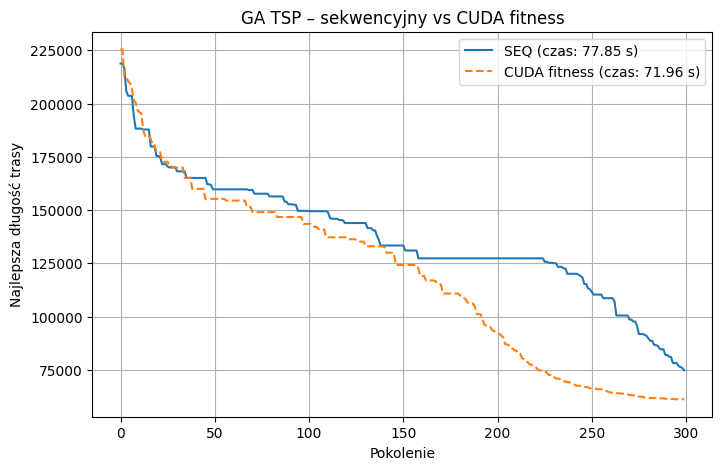

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(curve_seq, label=f"SEQ (czas: {time_seq:.2f} s)")
plt.plot(curve_cuda, label=f"CUDA fitness (czas: {time_cuda:.2f} s)", linestyle="--")
plt.xlabel("Pokolenie")
plt.ylabel("Najlepsza długość trasy")
plt.title("GA TSP – sekwencyjny vs CUDA fitness")
plt.grid(True)
plt.legend()
plt.show()


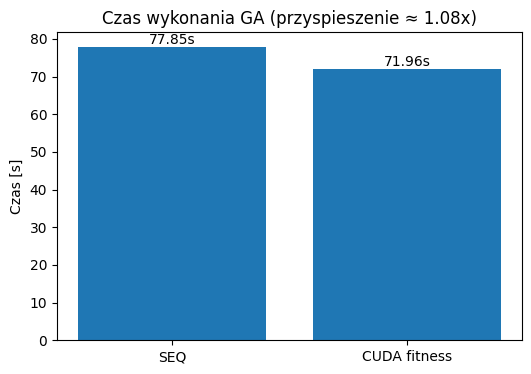

In [ ]:
plt.figure(figsize=(6, 4))
plt.bar(["SEQ", "CUDA fitness"], [time_seq, time_cuda])
plt.ylabel("Czas [s]")
plt.title(f"Czas wykonania GA (przyspieszenie ≈ {speedup:.2f}x)")
for i, v in enumerate([time_seq, time_cuda]):
    plt.text(i, v, f"{v:.2f}s", ha="center", va="bottom")
plt.show()
